#  5. 데이터 분산분석

## 1-1. ANOVA : Analysis of variance

분산 분석은 통계학에서 두 개 이상 다수의 집단을 서로 비교하고자 할 때 집단 내의 분산, 총평균 그리고 각 집단의 평균의 차이에 의해 생긴 집단 간 분산의 비교를 통해 만들어진 F분포를 이용하여 가설검정을 하는 방법

### 분석의 준비

In [1]:
# !pip install --user statsmodels==0.14.0 pydeseq2==0.4.3
# 커넬 리스타트

In [2]:
# !pip install statsmodels

In [3]:
# 수치 계산에 사용되는 라이브러리
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 그래프를 그리는 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 통계 모델을 추정하는 라이브러리
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 표시 소수점 자릿수 지정
%precision 3
# 그래프를 Jupyter Notebook 내에서 표시하기 위한 지정
%matplotlib inline

### 데이터 생성 및 표시

In [4]:
# 샘플 데이터 생성
weather = [
    "cloudy","cloudy",
    "rainy","rainy",
    "sunny","sunny"
]
homerun_ball = [6,8,2,4,10,12]

# 데이터프레임으로 결합
weather_homerun_ball = pd.DataFrame({
    "homerun_ball"   : homerun_ball,
    "weather": weather
})
print(weather_homerun_ball)

   homerun_ball weather
0             6  cloudy
1             8  cloudy
2             2   rainy
3             4   rainy
4            10   sunny
5            12   sunny


<AxesSubplot: xlabel='weather', ylabel='homerun_ball'>

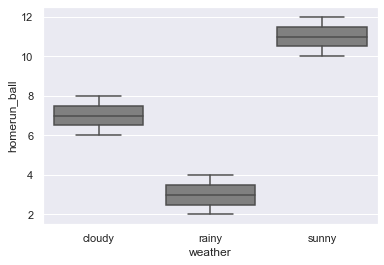

In [5]:
# 상자수염 그림 작성
sns.boxplot(x = "weather",y = "homerun_ball",
            data = weather_homerun_ball, color='gray')

In [6]:
# 각 데이터의 평균값
print(weather_homerun_ball.groupby("weather").mean())

         homerun_ball
weather              
cloudy            7.0
rainy             3.0
sunny            11.0


### 분산분석 ① 그룹 간 분산의 합과 그룹 내 분산의 합

In [7]:
# 날씨의 영향
effect = [7,7,3,3,11,11]

In [8]:
# 그룹 간 평균제곱 합
mu_effect = np.mean(effect)
squares_model = np.sum((effect - mu_effect) ** 2 )
squares_model

64.0

In [9]:
# 날씨로 설명할 수 없는 오차
resid = weather_homerun_ball.homerun_ball - effect
resid

0   -1
1    1
2   -1
3    1
4   -1
5    1
Name: homerun_ball, dtype: int64

In [10]:
# 오차제곱합
squares_resid = np.sum(resid ** 2)
squares_resid

6

### 분산 분석② 그룹간 분산과 그룹 내 분산

In [11]:
df_model = 2 # 그룹 간 변동의 자유도
df_resid = 3 # 그룹 내 변동의 자유도

In [12]:
# 그룹 간 분산
variance_model = squares_model / df_model
variance_model

32.0

In [13]:
# 그룹 내 분산
variance_resid = squares_resid / df_resid
variance_resid

2.0

### 분산분석 ③ p값 계산

 P-value란? P-value는 Probability-value의 줄임말로 확률 값을 뜻하며 어떤 사건이 우연히 발생할 확률을 말합니다.

통계적 가설 검정에서 유의 확률 또는 p-값은 귀무가설이 맞다고 가정할 때 얻은 결과보다 극단적인 결과가 실제로 관측될 확률입니다.    
실험의 유의확률은 실험의 표본 공간에서 정의되는 확률변수로서, 0~1 사이의 값을 가집니다.



In [16]:
# F 비율
f_ratio = variance_model / variance_resid
f_ratio

16.0

분산(variance, Var)은 통곗값과 평균값의 차이인 편차를 제곱하여 얻은 값들의 산술 평균이다. 분산이 작으면 자료는 평균값 주위에 모여 있게 되고, 분산이 크면 자료 가운데 평균값에서 멀리 떨어진 것이 많게 된다. 또한 개체(object)로부터 얻어진 데이타들의 집합인 샘플과 이러한 샘플들이 2개 이상이 되면 샘플들간의 평균의 분산을 얻을수있다. 이처럼 샘플내 분산값은 샘플들간이 평균분산에서 유의미성을 보여줄 수 있다. 

$${\displaystyle F={{\text{샘 플 간   평 균  분 산 }} \over {\text{샘 플 내   분 산 }}}}$$

In [17]:
# p 값
1 - sp.stats.f.cdf(x=f_ratio,dfn=df_model,dfd=df_resid)

0.02509457330439091

### statsmodels를 사용한 분산분석

In [18]:
# 정규 선형 모델 구축
anova_model = smf.ols("homerun_ball ~ weather", 
                      data = weather_homerun_ball).fit()

In [19]:
# 분산분석 결과
print(sm.stats.anova_lm(anova_model, typ=2))

          sum_sq   df     F    PR(>F)
weather     64.0  2.0  16.0  0.025095
Residual     6.0  3.0   NaN       NaN


### 모델 계수 해석

In [20]:
anova_model.params

Intercept           7.0
weather[T.rainy]   -4.0
weather[T.sunny]    4.0
dtype: float64

### 모델을 사용하여 오차와 효과 분리

In [21]:
#적합값
fitted = anova_model.fittedvalues
fitted

0     7.0
1     7.0
2     3.0
3     3.0
4    11.0
5    11.0
dtype: float64

In [22]:
# 잔차
anova_model.resid

0   -1.0
1    1.0
2   -1.0
3    1.0
4   -1.0
5    1.0
dtype: float64

### 회귀 모델에서의 분산분석

### 데이터 생성

In [29]:
import numpy as np
import pandas as pd

# 변수1 (홈런볼 판매수량)
mean1 = 50
max1 = 100
min1 = 10

# 변수2 (기온)
mean2 = 20
max2 = 40
min2 = -10

# 데이터 사이즈
data_size = 300

# 변수1과 변수2의 데이터 생성
variable1 = np.random.randint(min1, max1+1, data_size)
variable2 = np.round(np.random.uniform(min2, max2, data_size), 2)

# 데이터 프레임 생성
df = pd.DataFrame({
    'hr_ball_salses': variable1,
    'temperature': variable2
})

# CSV 파일로 저장
df.to_csv('homerun_ball_temp.csv', index=False)

# 결과 확인
print("변수1 (홈런볼 판매수량) 데이터 예시:", variable1[:10])
print("변수2 (기온) 데이터 예시:", variable2[:10])
print("데이터프레임 예시:")
print(df.head())


변수1 (홈런볼 판매수량) 데이터 예시: [54 90 92 27 13 63 83 34 79 45]
변수2 (기온) 데이터 예시: [13.95 33.31 24.24  9.75 24.47  0.42 19.29 17.72 17.82 -5.5 ]
데이터프레임 예시:
   hr_ball_salses  temperature
0              54        13.95
1              90        33.31
2              92        24.24
3              27         9.75
4              13        24.47


In [30]:
# 데이터 읽기
homerun_ball = pd.read_csv("homerun_ball_temp.csv")

# 모델 추정
lm_model = smf.ols(formula = "hr_ball_salses ~ temperature", 
                   data = homerun_ball).fit()

In [31]:
df_lm_model = 1  # 모델의 자유도
df_lm_resid = 28 # 잔차의 자유도

In [32]:
# 모델을 적용한 값
lm_effect = lm_model.fittedvalues

# 잔차
lm_resid = lm_model.resid

# 기온의 효과의 크기
mu = np.mean(lm_effect)
squares_lm_model = np.sum((lm_effect - mu) ** 2)
variance_lm_model = squares_lm_model / df_lm_model

# 잔차의 크기
squares_lm_resid = np.sum((lm_resid) ** 2)
variance_lm_resid = squares_lm_resid / df_lm_resid

# F비
f_value_lm = variance_lm_model / variance_lm_resid
f_value_lm

0.006401302058410296

In [33]:
# 참고: p값 (자릿수 버림으로 0이 됨)|
1 - sp.stats.f.cdf(
    x=f_value_lm,dfn=df_lm_model,dfd=df_lm_resid)

0.9367998992013534

In [34]:
# 분산분석 테이블
print(sm.stats.anova_lm(lm_model, typ=2))

                   sum_sq     df         F    PR(>F)
temperature      46.42906    1.0  0.068128  0.794262
Residual     203085.82094  298.0       NaN       NaN


In [35]:
# 모델 summary
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hr_ball_salses   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.06813
Date:                Tue, 06 Feb 2024   Prob (F-statistic):              0.794
Time:                        21:34:49   Log-Likelihood:                -1403.3
No. Observations:                 300   AIC:                             2811.
Df Residuals:                     298   BIC:                             2818.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      56.2031      2.281     24.638      0.000      51.714      60.692
temperature     0.0277      0.106      0.261      0.794      -0.181       0.237
==============================================================================
Omnibus:                      115.206   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.076
Skew:                          -0.126   Prob(JB):                     0.000196
Kurtosis:                       1.859   Cond. No.                         32.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""